# Special Model Comparison

---

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBClassifier

%load_ext autoreload
%autoreload 2

In [2]:
from util import databases
from util import dataloader
from util import grid_models
from util.reddit_functions import Labeler
from util.reddit_functions import plot_confusion_matrix
from util.grid_models import custom_stop_words

In [3]:
def build_and_train_model(preprocessor, classifier, cv=3, verbose=1):
    '''
    Takes a dictionary with params and outputs a fitted model
    '''
    pipe = Pipeline(
    [('prep', preprocessor.get('preprocessor')),
     ('clf', classifier.get('clf'))])
    
    pipe_params = dict()
    pipe_params.update(preprocessor.get('params'))
    pipe_params.update(classifier.get('params'))
    
    model = GridSearchCV(pipe, param_grid=pipe_params, cv=cv, verbose=verbose, n_jobs=-1)
    model.fit(X_train, y_train)
    return model

In [4]:
def score_model(model):
    
    print(f'Train Score: {model.score(X_train, y_train)}')
    print(f'Test Score: {model.score(X_test, y_test)}')
    print(f'AUC Score: {roc_auc_score(y_test, y_proba, multi_class="ovr")}')
    print(classification_report(y_test, y_pred, digits=3))

In [5]:
# subreddit_list = ['css', 'html', 'javascript', 'php', 'perl', 'java', 'datascience', 'machinelearning', 'etl', 'python', 'dataengineering']

In [6]:
subreddit_list = ['datascience','machinelearning','dataengineering','python','aws']

In [7]:
df = dataloader.data_selector(subreddit_list, 'sqlite')

Connection to SQLite DB successful


In [8]:
df.sample(10)

,title,subreddit,date
56346,Make an exe with python,python,2020-04-28
34440,Use s3 presigned urls for zip files &amp; auto...,aws,2020-04-23
43876,[Activate] I work for an old company that is v...,aws,2020-04-25
58075,Aws ALB just for token verification,aws,2020-04-29
22381,Python Math Game Challenge,python,2020-04-20
61834,Data Modeling Question,dataengineering,2020-04-29
38821,Trying to add an SSH key into authorized_keys ...,aws,2020-04-24
11754,[N] Default TensorFlow version in Colab switch...,machinelearning,2020-04-10
24681,[Help] Need help with auto scaling,aws,2020-04-21
20739,International Students beware of Data Science ...,datascience,2020-04-20


In [9]:
X = df['title']
y = df['subreddit']

In [10]:
labeler = Labeler()
labeler.fit(y)
y = labeler.transform(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

In [12]:
tfidf = {
    'preprocessor': TfidfVectorizer(stop_words=custom_stop_words),
    'params': {
        "prep__ngram_range": [(1, 2)],
#         "prep__max_df": [.7, .8, .9],
        "prep__use_idf": [True],
        "prep__norm": ["l2"]
    }
}

In [13]:
lr = {
    'name': 'lr',
    'clf': LogisticRegression(max_iter=1000),
    'params': {
        "clf__C": [5]
    }
    
}

In [14]:
mlp = {
    'name': 'mlp',
    'clf': MLPClassifier(),
    'params': {
        "clf__hidden_layer_sizes": [50, 100, 200]
    }
}

In [15]:
xgb = {
    'name': 'xgb',
    'clf': XGBClassifier(),
    'params': {
        "clf__hidden_layer_sizes": [10, 25, 50],
        "clf__n_estimators": [50, 100, 200],
        "clf__max_depth": [5, 10, 20]
    }
}

In [16]:
onevrest = {
    'name': 'onevrest',
    'clf': OneVsRestClassifier(RandomForestClassifier()),
    'params': {
        "clf__estimator__n_estimators": [200, 300]
    }
}

In [17]:
fitted_models = dict()

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.8s finished


Train Score: 0.9930142302716688
Test Score: 0.9860293642067137
AUC Score: 0.9979281427493124
              precision    recall  f1-score   support

           0      0.992     0.995     0.994      3194
           1      0.980     0.986     0.983      2828
           2      0.989     0.989     0.989      3286
           3      0.981     0.978     0.980      2913
           4      0.986     0.981     0.984      3240

    accuracy                          0.986     15461
   macro avg      0.986     0.986     0.986     15461
weighted avg      0.986     0.986     0.986     15461

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 75.2min finished


Train Score: 0.9934670116429496
Test Score: 0.9859646853373003
AUC Score: 0.9994598383148716
              precision    recall  f1-score   support

           0      0.990     0.995     0.993      3194
           1      0.984     0.984     0.984      2828
           2      0.989     0.991     0.990      3286
           3      0.986     0.972     0.979      2913
           4      0.980     0.986     0.983      3240

    accuracy                          0.986     15461
   macro avg      0.986     0.986     0.986     15461
weighted avg      0.986     0.986     0.986     15461

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 54.7min finished


Train Score: 0.9892194911599828
Test Score: 0.9787206519630037
AUC Score: 0.9983602476716594
              precision    recall  f1-score   support

           0      0.990     0.985     0.987      3194
           1      0.963     0.984     0.974      2828
           2      0.992     0.977     0.985      3286
           3      0.968     0.964     0.966      2913
           4      0.978     0.982     0.980      3240

    accuracy                          0.979     15461
   macro avg      0.978     0.979     0.978     15461
weighted avg      0.979     0.979     0.979     15461

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/datapointchris/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 12.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 12.0min finished


Train Score: 0.9937257438551099
Test Score: 0.98538257551258
AUC Score: 0.9995858152353879
              precision    recall  f1-score   support

           0      0.991     0.994     0.992      3194
           1      0.980     0.984     0.982      2828
           2      0.991     0.986     0.989      3286
           3      0.988     0.974     0.981      2913
           4      0.976     0.987     0.982      3240

    accuracy                          0.985     15461
   macro avg      0.985     0.985     0.985     15461
weighted avg      0.985     0.985     0.985     15461



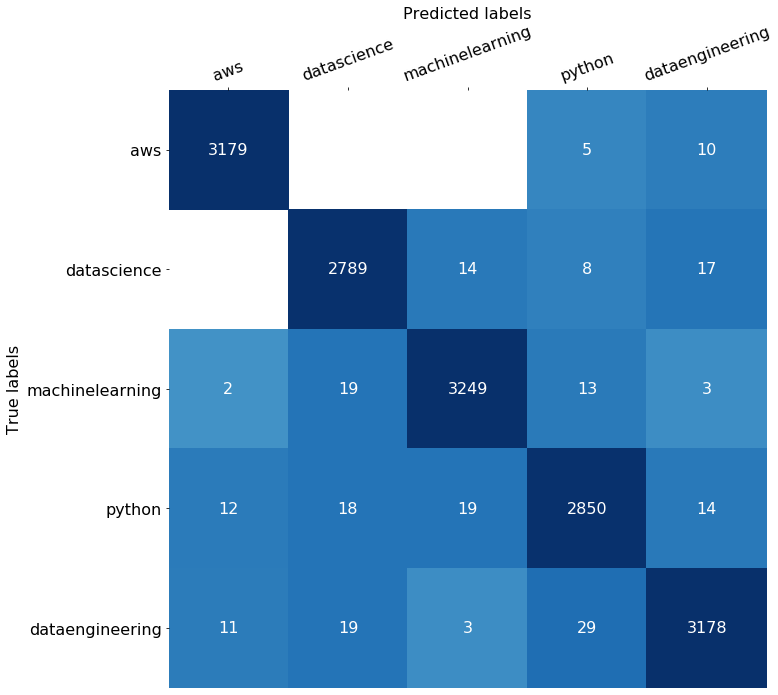

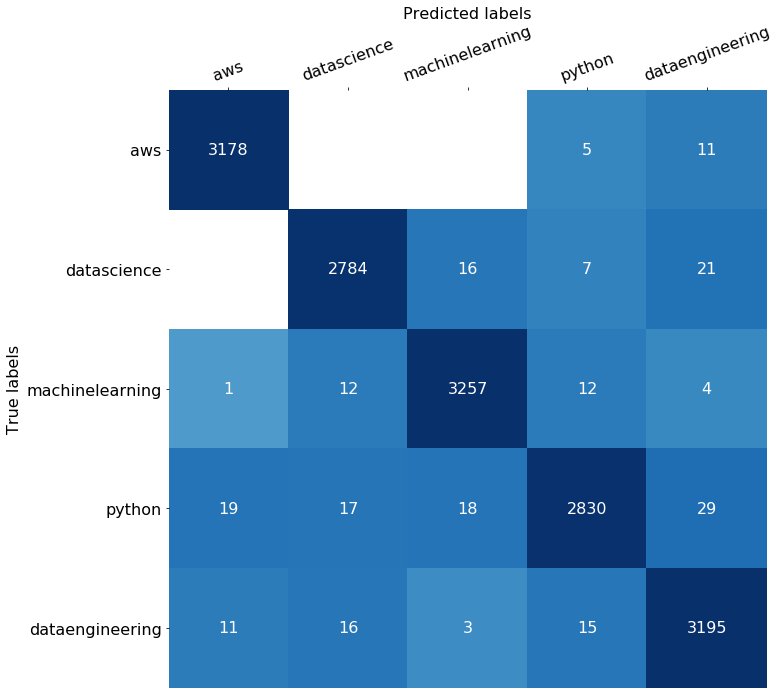

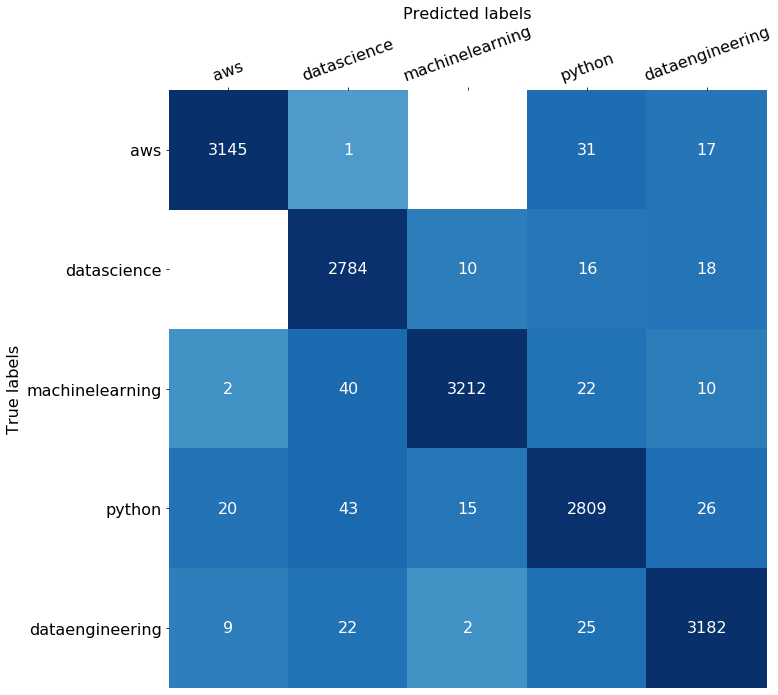

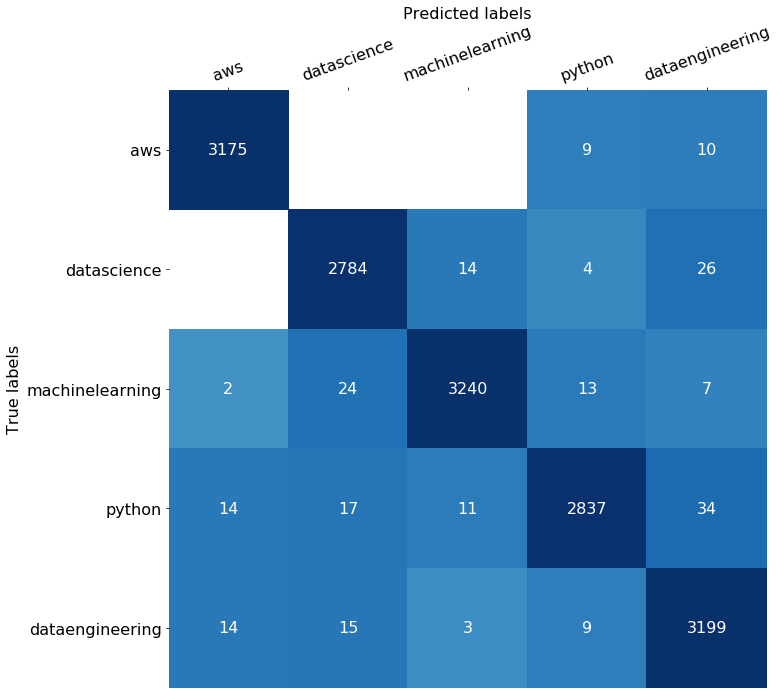

In [18]:
for estimator in [lr, mlp, xgb, onevrest]:
    
    model = build_and_train_model(preprocessor=tfidf, classifier=estimator)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    score_model(model)
    plot_confusion_matrix(model, y_true=y_test, y_pred=y_pred, classes=labeler.classes_)
    fitted_models[estimator.get('name')] = model

In [19]:
fitted_models

{'lr': GridSearchCV(cv=3, error_score=nan,
              estimator=Pipeline(memory=None,
                                 steps=[('prep',
                                         TfidfVectorizer(analyzer='word',
                                                         binary=False,
                                                         decode_error='strict',
                                                         dtype=<class 'numpy.float64'>,
                                                         encoding='utf-8',
                                                         input='content',
                                                         lowercase=True,
                                                         max_df=1.0,
                                                         max_features=None,
                                                         min_df=1,
                                                         ngram_range=(1, 1),
                                      